# Método Runge-Kutta 4

El método RK4 trunca una expansión de Taylor hasta un orden de exactitud h⁴; 3 órdenes de magnitud mayor que el método de Euler.
El step de diferencia finita está dado por
$$ y_ {n + 1} = y_n + \tfrac{h}{6} \left (k_1 + 2k_2 + 2k_3 + k_4 \right), $$

dónde
$$ \begin{align} k_1 & = f (t_n, y_n), \\ k_2 & = f (t_n + \tfrac{h}{2}, y_n + \tfrac{h}{2} k_1), \\ k_3 & = f (t_n + \tfrac{h}{2}, y_n + \tfrac{h}{2} k_2), \\ k_4 & = f (t_n + h, y_n + h k_3). \end{align} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Implementando el método
definiremos una función para implementar el método Runge-Kutta para un sistema ODE de primer orden.

In [2]:
def ode_int_rk(func, y_0, t, args={}):
    """Aproximación RK4 a un sistema de ecuaciones de primer orden (ODE) 
    con condiciones iniciales
    Args:
       func: el sistema de ecuaciones para aproximar
        y_0: (arreglo) condición inicial.
        t: (arreglo) Secuencia de puntos temporales para los que se va a resolver y.
            args: argumentos extra para la función

        Out:
            y: (arreglo) la solución aproximada del sistema en cada tiempo t,
                con el valor inicial de y_0 en la primer fila

    Out:
        y: (array) the approximated solution of the system at each time in t,
            with the initial value y_0 in the first row.
    """

    # Inicia el arreglo de las aproximaciones
    y = np.zeros([len(t), len(y_0)])
    y[0] = y_0

    # Loop a través de time steps, aproximando este step de los prev step
    for i, t_i in enumerate(t[:-1]):

        h = t[i+1] - t_i # tamaño  step

        k_1 = func(t_i, y[i], args)
        k_2 = func(t_i+h/2., y[i]+h/2.*k_1, args)
        k_3 = func(t_i+h/2., y[i]+h/2.*k_2, args)
        k_4 = func(t_i+h, y[i]+h*k_3, args)

        y[i+1] = y[i] + h/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step

    return y

### Exactitud
Veremos la exactitud de esta aproximación con una función exponencial, teniendo varios steps.

In [3]:
def exp(t, y, args):
    """ función exponencial como sistema de ecuaciones ODE. """
    
    dydt = args['a']*y
    return dydt

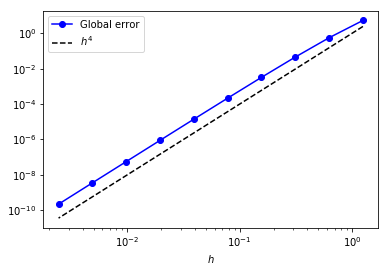

In [4]:
y_0 = np.array([1.]) # Initial condition

solve_args = {}
solve_args['a'] = 1.

t_max = 5.

# Range of stepsizes
max_N = 12
N = 2**np.arange(2, max_N) # N = 2, 4, 8, ..., 2^max_N

order_check = 4 # for visual check of the order of accuracy

y_end = np.zeros(len(N)) # array to fill with the final values
stepsize = np.zeros(len(N)) # array to fill with the stepsizes

for i, N_i in enumerate(N): # loop over different numbers of steps

    t = np.linspace(0., t_max, N_i+1)
    y_end[i] = ode_int_rk(exp, y_0, t, solve_args)[-1]
    
    stepsize[i] = t_max/N_i
    
plt.loglog(stepsize, abs(y_end - np.exp(solve_args['a']*t_max)), 
           'b-o', label='Global error')
plt.loglog(stepsize, stepsize**order_check,'k--', label=r'$h^4$')
plt.xlabel(r'$h$')
plt.legend(loc=2)

Así que hemos confirmado que el método de Runge-Kutta de orden h⁴  - de modo que el error global se reduce mucho más rápido con un número de pasos mayor que el Euler explícito.

## Ejemplo 2: un péndulo forzado y amortiguado
El siguiente problema que veremos es un ODE de segundo orden, pero es crucial que cualquier ODE de orden superior se pueda reescribir como un conjunto de ecuaciones de primer orden acopladas. Veremos cómo hacerlo con este ejemplo.

Tomemos un péndulo ideal: una cuerda sin de longitud $ \ell $, fijada en un extremo con una masa $ m $ en el otro. El péndulo puede balancearse libremente en un plano sujeto a la gravedad, una fricción proporcional a su velocidad $ v $, y puede ser impulsado por una fuerza periódica externa $ F_d \ cos {\omega_d t} $.

Comenzamos con la segunda ley de Newton aplicada al desplazamiento horizontal $ x $ para el péndulo no forzado y no amortiguado,
$$ m \ddot {x} = -mg \sin {\theta} $$

donde $ g $ es la aceleración local debida a la gravedad y $ \theta {(t)} $ es el ángulo de desplazamiento de la cuerda desde la vertical en el tiempo $ t $. Ahora aplicamos una fuerza de fricción proporcional a la velocidad de traslación y reorganizamos para obtener una ecuación diferencial homogénea de segundo orden,
$$ m \ddot {x} + k \ell \dot {x} + mg \sin {\theta} = 0 $$

donde $ k $ es el coeficiente de fricción.

Queremos considerar el desplazamiento angular, por lo que sustituimos $ \dot {x} = \ell \dot {\theta} $ y $ \ddot {x} = \ell \ddot {\theta} $, y ahora aplicamos la fuerza motriz
$$ m \ell \ddot {\theta} + k \ell \dot{\theta} + mg \sin {\theta} = F_d \cos {\omega_d t} $$

La ecuación es no lineal (debido a la función seno), por lo que encontrar una solución analítica va a ser difícil, entonces probaremos nuestro método de Runge-Kutta sobre el problema. Primero debemos reescribir la ecuación de segundo orden como un conjunto de ecuaciones de primer orden acopladas. Sea $ y_0 = \theta $, $ y_1 = \dot {\theta} $ y $ y_2 = \ddot {\theta} $.

In [5]:
def pendulum(t, y, args):
    """ A damped and forced pendulum, described as set of two first-order ODEs.

    Args:
        t: Time
        y: Pendulum system vector [angle, angular velocity] 
        args['alpha']: gravity_acc/length_of_pendulum
        args['beta']: friction_constant/mass_pendulum
        args['gamma']: driving_force/mass_pendulum/length_pendulum
        args['omega']: driving_freq

    Returns:
        dydt: ODE vector
    """

    dydt = np.zeros(2)

    dydt[0] = y[1]
    dydt[1] = (-args['alpha']*np.sin(y[0]) - args['beta']*y[1] + 
                args['gamma']*np.cos(args['omega']*t))

    return dydt


Ahora estamos listos para seleccionar algunos parámetros. Primero eliminaremos la fricción ( k = 0 ) y no aplicaremos ninguna fuerza motriz ($F_d$ = 0 ), bajo qué condiciones esperamos ver un movimiento armónico simple del péndulo hacia adelante y hacia atrás.

In [6]:


### Parameters

gravity_acc = 10. # [m /s2]

length_pendulum = 1. # [m]
mass_pendulum = 1. # [kg]
friction_constant = 0. # [kg /m /s]

driving_force = 0. # [N]
driving_freq = 0. # [2π /s]

N = 200

t = np.linspace(0., 10., N+1) # [s] an array of time steps




Resolvemos los argumentos que definimos 

In [7]:
solve_args = {}
solve_args['alpha'] = gravity_acc/length_pendulum
solve_args['beta'] = friction_constant/mass_pendulum
solve_args['gamma'] = driving_force/mass_pendulum/length_pendulum
solve_args['omega'] = driving_freq

Luego necesitamos algunas condiciones iniciales. Seleccionamos $ \theta_0 = \tfrac {\pi} {8} $ para que podamos verificar nuestro resultado numérico con la aproximación de ángulo pequeño,
$$ \sin \theta \approx \theta. $$

Con esta aproximación, la solución no amortiguada y no reforzada se puede encontrar analíticamente: $ y = y_0 \cos (\sqrt {\alpha} t)

In [8]:
initial_ang = np.pi/8 # [rad]
initial_ang_vel = 0. # [rad /s]

initial_cond = np.array([initial_ang, initial_ang_vel])

## Resolviendo el problema

Ahora podemos resolver el sistema ODE utilizando el método Runge-Kutta que hicimos anteriormente y trazar el ángulo $ y_0 $ con el tiempo

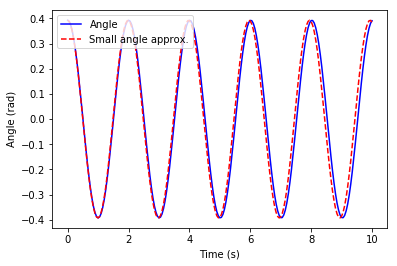

In [9]:
from scipy.integrate import odeint

# y = odeint(pendulum, initial_cond, t, args=(solve_args,))

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

y_small_ang = initial_ang*np.cos(np.sqrt(solve_args['alpha'])*t)

plt.plot(t, y[:,0], c='b', label='Angle')
plt.plot(t, y_small_ang, 'r--', label='Small angle approx.')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend(loc=2)



Así que vemos que el péndulo oscila según lo esperado y la frecuencia coincide con el resultado de ángulo pequeño conocido razonablemente bien para unos pocos cambios. (Podríamos intentar hacer que initial_ang sea más grande o más pequeño para ver dónde funciona la aproximación).

Otras perspectivas que pueden interesarnos son la trayectoria del péndulo en el espacio de fase, que graficamos en un diagrama de fase y sus propiedades espectrales, a través de un espectro de potencia.

In [12]:
def plot_pendulum(t,y):
    """ Plot Angle, Phase Diagram, FFT. """
    
    fig = plt.figure()

    # Plot Angle
    ax_1 = fig.add_subplot(211)
    ax_1.plot(t, y[:,0], c='b')
    ax_1.set_xlabel('Time (s)')
    ax_1.set_ylabel('Angle (rad)')
    
    # Plot Phase Diagram
    ax_2 = fig.add_subplot(223)
    ax_2.plot(y[:,0], y[:,1], c='g')
    ax_2.set_xlabel('Angle (rad)')
    ax_2.set_ylabel('Angular Velocity (rad /s)')
    
    # Fourier Transform
    f_fft = np.fft.fftfreq(len(t), t[1]-t[0])
    y_fft = np.fft.fft(y[:,0])/np.sqrt(2*len(t))
    
    # Plot Power Spectrum
    ax_3 = fig.add_subplot(224)
    ax_3.plot(f_fft[:N]*2*np.pi, abs(y_fft[:N]), c='r')
    ax_3.set_xlim([0, 30])
    ax_3.set_xlabel('Ang Freq ($2 \pi$ Hz)')
    ax_3.set_ylabel('Power')


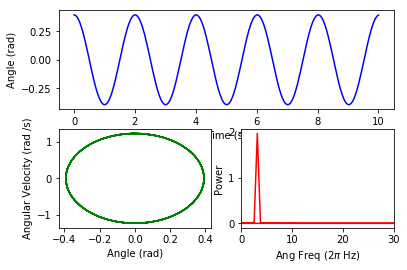

In [13]:
plot_pendulum(t,y)


## Añadiendo fricción


Para modelar mejor un péndulo físico, podríamos agregar una constante de fricción $ k $, y ver qué sucede cuando resolvemos el sistema con esto incluido.

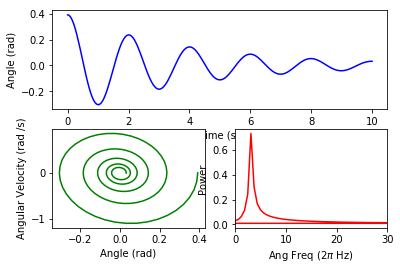

In [14]:
friction_constant = .5 # [kg /m /s]
solve_args['beta'] = friction_constant/mass_pendulum

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

plot_pendulum(t,y)



El diagrama de fase (verde, abajo a la izquierda) muestra cada estado físico posible para el sistema. Vemos que el péndulo no amortiguado y no forzado sigue una órbita regular.

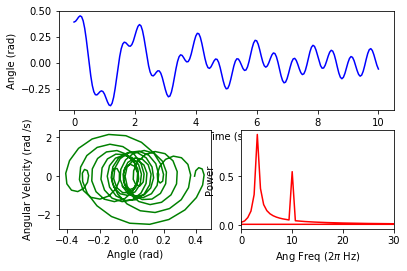

In [15]:
driving_force = 10. # [N]
driving_freq = 10. # [2π /s]

solve_args['gamma'] = driving_force/mass_pendulum/length_pendulum
solve_args['omega'] = driving_freq

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

plot_pendulum(t,y)

Vemos que con el tiempo la fricción atenúa el balanceo del péndulo. La trayectoria del espacio fase ya no orbita de manera consistente, sino que se mueve en espiral.